In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sidharkal/sports-image-classification")

print("Path to dataset files:", path)

100%|██████████| 826M/826M [00:09<00:00, 89.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sidharkal/sports-image-classification/versions/1


In [2]:
import pandas as pd

In [3]:
import os

In [14]:
# Define file paths
train_csv = path + "/dataset/train.csv"
test_csv = path + "/dataset/test.csv"
image_directory =image_directory = path + "/dataset/train/"
# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8227, 2)
Test shape: (2056, 1)


<Axes: xlabel='label', ylabel='count'>

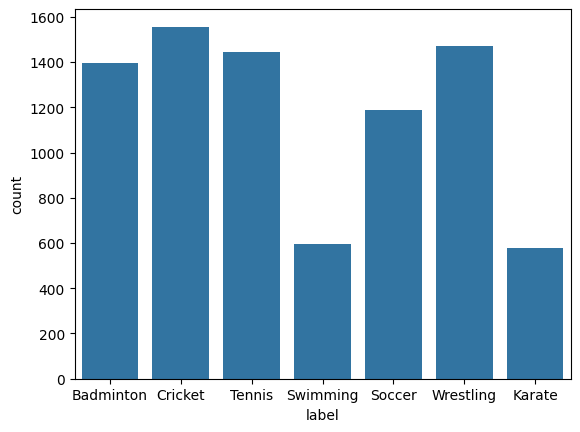

In [15]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [16]:
import cv2

In [17]:
train

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


# **Upsampling**

In [18]:
import os
import cv2
import pandas as pd

# Classes to process
target_classes = ["Swimming", "Karate"]

# Filter the train data for the target classes
filtered_data = train[train["label"].isin(target_classes)]
print(filtered_data)
# Loop through the filtered data
for _, row in filtered_data.iterrows():
    image_id = row["image_ID"]  # File name
    label = row["label"]  # Class label

    # Construct the input image path
    image_path = os.path.join(image_directory, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)

        # Define new sizes for upsampling and downsampling
        new_size_up = (image.shape[1] * 2, image.shape[0] * 2)  # Double size
        #new_size_down = (image.shape[1] // 2, image.shape[0] // 2)  # Half size

        # Perform resizing (choose upsampling or downsampling as needed)
        # Uncomment one of these lines based on your goal:
        image = cv2.resize(image, new_size_up, interpolation=cv2.INTER_LINEAR)  # Upsampling
        #image = cv2.resize(image, new_size_down, interpolation=cv2.INTER_LINEAR)  # Downsampling

        # Save the modified image back to the same path
        cv2.imwrite(image_path, image)
        print(f"Modified {image_id} ({label}) directly in the train folder.")
    else:
        print(f"Image {image_id} not found in {image_directory}.")

print("Modification complete for selected classes.")


            image_ID     label
7     da4d3e218c.jpg  Swimming
29    84f0137b10.jpg  Swimming
30    f97066d496.jpg  Swimming
36    c7657216ce.jpg    Karate
37    6a2d3a4a4c.jpg  Swimming
...              ...       ...
8206  e5d42b9d58.jpg    Karate
8217  ff72ce24ac.jpg  Swimming
8219  a7080caa11.jpg    Karate
8221  ea6b657b01.jpg    Karate
8226  f07f00564e.jpg  Swimming

[1173 rows x 2 columns]
Modified da4d3e218c.jpg (Swimming) directly in the train folder.
Modified 84f0137b10.jpg (Swimming) directly in the train folder.
Modified f97066d496.jpg (Swimming) directly in the train folder.
Modified c7657216ce.jpg (Karate) directly in the train folder.
Modified 6a2d3a4a4c.jpg (Swimming) directly in the train folder.
Modified 1d82aeffe8.jpg (Swimming) directly in the train folder.
Modified 8116da71f7.jpg (Karate) directly in the train folder.
Modified fcb5b0e345.jpg (Swimming) directly in the train folder.
Modified 4c03de88f8.jpg (Karate) directly in the train folder.
Modified c5063.jpg (Swim

In [19]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [20]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = path + "/dataset/train"
test_img_dir = test_csv + "dataset/test"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

# ResNet50

In [21]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.57it/s]


Epoch [1/5], Training Loss: 1.0064, Training Accuracy: 0.6534


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Epoch [1/5], Validation Loss: 1.0249, Validation Accuracy: 0.6774


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:22<00:00,  2.51it/s]


Epoch [2/5], Training Loss: 0.6424, Training Accuracy: 0.7789


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Epoch [2/5], Validation Loss: 0.8147, Validation Accuracy: 0.7430


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:17<00:00,  2.66it/s]


Epoch [3/5], Training Loss: 0.5012, Training Accuracy: 0.8322


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]


Epoch [3/5], Validation Loss: 0.8824, Validation Accuracy: 0.7363


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.71it/s]


Epoch [4/5], Training Loss: 0.3914, Training Accuracy: 0.8658


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]


Epoch [4/5], Validation Loss: 0.4892, Validation Accuracy: 0.8378


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:15<00:00,  2.71it/s]


Epoch [5/5], Training Loss: 0.3306, Training Accuracy: 0.8862


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]

Epoch [5/5], Validation Loss: 0.5142, Validation Accuracy: 0.8341
Training completed.


# VGG16

In [22]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.4MB/s]


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:23<00:00,  2.47it/s]


Epoch [1/5], Training Loss: 1.9773, Training Accuracy: 0.2314


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:19<00:00,  2.72it/s]


Epoch [1/5], Validation Loss: 1.6434, Validation Accuracy: 0.2801


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.56it/s]


Epoch [2/5], Training Loss: 1.5604, Training Accuracy: 0.3819


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]


Epoch [2/5], Validation Loss: 1.4438, Validation Accuracy: 0.4192


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:25<00:00,  2.40it/s]


Epoch [3/5], Training Loss: 1.4006, Training Accuracy: 0.4539


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]


Epoch [3/5], Validation Loss: 1.3388, Validation Accuracy: 0.4721


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:22<00:00,  2.51it/s]


Epoch [4/5], Training Loss: 1.3404, Training Accuracy: 0.4998


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


Epoch [4/5], Validation Loss: 1.2894, Validation Accuracy: 0.5213


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.55it/s]


Epoch [5/5], Training Loss: 1.2457, Training Accuracy: 0.5361


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]

Epoch [5/5], Validation Loss: 1.0743, Validation Accuracy: 0.5984
Training with VGG16 completed.


# GoogLeNet

In [23]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 79.8MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.56it/s]


Epoch [1/5], Training Loss: 0.6268, Training Accuracy: 0.7868


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Epoch [1/5], Validation Loss: 0.6714, Validation Accuracy: 0.7697


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.69it/s]


Epoch [2/5], Training Loss: 0.3475, Training Accuracy: 0.8851


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Epoch [2/5], Validation Loss: 0.4461, Validation Accuracy: 0.8469


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:15<00:00,  2.72it/s]


Epoch [3/5], Training Loss: 0.2570, Training Accuracy: 0.9108


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]


Epoch [3/5], Validation Loss: 0.4603, Validation Accuracy: 0.8542


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.70it/s]


Epoch [4/5], Training Loss: 0.1884, Training Accuracy: 0.9368


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]


Epoch [4/5], Validation Loss: 0.4181, Validation Accuracy: 0.8657


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:21<00:00,  2.54it/s]


Epoch [5/5], Training Loss: 0.1694, Training Accuracy: 0.9406


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]

Epoch [5/5], Validation Loss: 0.2706, Validation Accuracy: 0.9070
Training with GoogLeNet completed.


# AlexNet

In [24]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 143MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:09<00:00,  2.98it/s]


Epoch [1/5], Training Loss: 1.9724, Training Accuracy: 0.1814


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epoch [1/5], Validation Loss: 1.8878, Validation Accuracy: 0.1847


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:10<00:00,  2.94it/s]


Epoch [2/5], Training Loss: 1.8925, Training Accuracy: 0.1767


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Epoch [2/5], Validation Loss: 1.8842, Validation Accuracy: 0.1744


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:10<00:00,  2.92it/s]


Epoch [3/5], Training Loss: 1.8900, Training Accuracy: 0.1877


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]


Epoch [3/5], Validation Loss: 1.8879, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:10<00:00,  2.92it/s]


Epoch [4/5], Training Loss: 1.9135, Training Accuracy: 0.1778


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.35it/s]


Epoch [4/5], Validation Loss: 1.8927, Validation Accuracy: 0.1756


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:08<00:00,  3.02it/s]


Epoch [5/5], Training Loss: 1.8892, Training Accuracy: 0.1869


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]

Epoch [5/5], Validation Loss: 1.8952, Validation Accuracy: 0.1847
Training with AlexNet completed.


# **Downsampling**

In [27]:
 # Define file paths
train_csv = path + "/dataset/train.csv"
test_csv = path + "/dataset/test.csv"
image_directory =image_directory = path + "/dataset/train/"
# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)
import os
import cv2
import pandas as pd

# Classes to process
target_classes = ["Cricket", "Wrestling"]

# Filter the train data for the target classes
filtered_data = train[train["label"].isin(target_classes)]
print(filtered_data)
# Loop through the filtered data
for _, row in filtered_data.iterrows():
    image_id = row["image_ID"]  # File name
    label = row["label"]  # Class label

    # Construct the input image path
    image_path = os.path.join(image_directory, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)

        # Define new sizes for upsampling and downsampling
        #new_size_up = (image.shape[1] * 2, image.shape[0] * 2)  # Double size
        new_size_down = (max(image.shape[1] // 2, 1), max(image.shape[0] // 2, 1))  # Half size
        # Perform resizing (choose upsampling or downsampling as needed)
        # Uncomment one of these lines based on your goal:
        #image = cv2.resize(image, new_size_up, interpolation=cv2.INTER_LINEAR)  # Upsampling
        image = cv2.resize(image, new_size_down, interpolation=cv2.INTER_LINEAR)  # Downsampling

        # Save the modified image back to the same path
        cv2.imwrite(image_path, image)
        print(f"Modified {image_id} ({label}) directly in the train folder.")
    else:
        print(f"Image {image_id} not found in {image_directory}.")

print("Modification complete for selected classes.")


Train shape: (8227, 2)
Test shape: (2056, 1)
            image_ID      label
4     cfd2c28c74.jpg    Cricket
10    cdddf0986c.jpg    Cricket
16    598474c7b4.jpg    Cricket
17    772648a478.jpg  Wrestling
21    89ce36a3ec.jpg  Wrestling
...              ...        ...
8207  f8befcae17.jpg    Cricket
8210  e347af0df6.jpg    Cricket
8213  fb1afffcf1.jpg  Wrestling
8215  5e04258d16.jpg    Cricket
8222  903d2fffb3.jpg    Cricket

[3027 rows x 2 columns]
Modified cfd2c28c74.jpg (Cricket) directly in the train folder.
Modified cdddf0986c.jpg (Cricket) directly in the train folder.
Modified 598474c7b4.jpg (Cricket) directly in the train folder.
Modified 772648a478.jpg (Wrestling) directly in the train folder.
Modified 89ce36a3ec.jpg (Wrestling) directly in the train folder.
Modified 28e511a3b9.jpg (Cricket) directly in the train folder.
Modified 4e13ff214a.jpg (Cricket) directly in the train folder.
Modified 88199f586e.jpg (Wrestling) directly in the train folder.
Modified 96d7e3d2a6.jpg (Cri

# ResNet50

In [28]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training:   0%|          | 0/206 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5 - Training: 100%|██████████| 206/206 [01:01<00:00,  3.37it/s]


Epoch [1/5], Training Loss: 1.8895, Training Accuracy: 0.1899


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epoch [1/5], Validation Loss: 1.8845, Validation Accuracy: 0.1847


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:59<00:00,  3.46it/s]


Epoch [2/5], Training Loss: 1.8860, Training Accuracy: 0.1901


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.35it/s]


Epoch [2/5], Validation Loss: 1.8842, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [00:59<00:00,  3.46it/s]


Epoch [3/5], Training Loss: 1.8862, Training Accuracy: 0.1902


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.41it/s]


Epoch [3/5], Validation Loss: 1.8847, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:03<00:00,  3.26it/s]


Epoch [4/5], Training Loss: 1.8861, Training Accuracy: 0.1875


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.65it/s]


Epoch [4/5], Validation Loss: 1.8848, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:59<00:00,  3.46it/s]


Epoch [5/5], Training Loss: 1.8863, Training Accuracy: 0.1904


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.71it/s]

Epoch [5/5], Validation Loss: 1.8846, Validation Accuracy: 0.1847
Training completed.


# VGG16

In [29]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.79it/s]


Epoch [1/5], Training Loss: 1.9790, Training Accuracy: 0.1764


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.28it/s]


Epoch [1/5], Validation Loss: 1.8921, Validation Accuracy: 0.1744


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:11<00:00,  2.87it/s]


Epoch [2/5], Training Loss: 1.8942, Training Accuracy: 0.1833


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.43it/s]


Epoch [2/5], Validation Loss: 1.8976, Validation Accuracy: 0.1701


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.69it/s]


Epoch [3/5], Training Loss: 1.8948, Training Accuracy: 0.1773


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.40it/s]


Epoch [3/5], Validation Loss: 1.8918, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:12<00:00,  2.84it/s]


Epoch [4/5], Training Loss: 1.8934, Training Accuracy: 0.1788


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]


Epoch [4/5], Validation Loss: 1.8871, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:12<00:00,  2.83it/s]


Epoch [5/5], Training Loss: 1.8919, Training Accuracy: 0.1808


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]

Epoch [5/5], Validation Loss: 1.8912, Validation Accuracy: 0.1744
Training with VGG16 completed.


# GoogLeNet

In [30]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:14<00:00,  2.77it/s]


Epoch [1/5], Training Loss: 0.6568, Training Accuracy: 0.7751


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.96it/s]


Epoch [1/5], Validation Loss: 0.4475, Validation Accuracy: 0.8475


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:05<00:00,  3.14it/s]


Epoch [2/5], Training Loss: 0.3564, Training Accuracy: 0.8740


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.26it/s]


Epoch [2/5], Validation Loss: 0.5037, Validation Accuracy: 0.8366


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:04<00:00,  3.20it/s]


Epoch [3/5], Training Loss: 0.2712, Training Accuracy: 0.9078


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


Epoch [3/5], Validation Loss: 0.4074, Validation Accuracy: 0.8657


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:05<00:00,  3.13it/s]


Epoch [4/5], Training Loss: 0.2072, Training Accuracy: 0.9295


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.87it/s]


Epoch [4/5], Validation Loss: 0.3099, Validation Accuracy: 0.8943


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.80it/s]


Epoch [5/5], Training Loss: 0.1490, Training Accuracy: 0.9489


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.41it/s]

Epoch [5/5], Validation Loss: 0.2658, Validation Accuracy: 0.9149
Training with GoogLeNet completed.


# AlexNet

In [31]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:03<00:00,  3.27it/s]


Epoch [1/5], Training Loss: 1.9037, Training Accuracy: 0.1969


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]


Epoch [1/5], Validation Loss: 1.8909, Validation Accuracy: 0.1756


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:01<00:00,  3.36it/s]


Epoch [2/5], Training Loss: 1.8913, Training Accuracy: 0.1857


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.93it/s]


Epoch [2/5], Validation Loss: 1.8872, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:00<00:00,  3.41it/s]


Epoch [3/5], Training Loss: 1.8920, Training Accuracy: 0.1811


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.49it/s]


Epoch [3/5], Validation Loss: 1.8853, Validation Accuracy: 0.1744


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:06<00:00,  3.09it/s]


Epoch [4/5], Training Loss: 1.8888, Training Accuracy: 0.1826


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s]


Epoch [4/5], Validation Loss: 1.8870, Validation Accuracy: 0.1756


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:01<00:00,  3.32it/s]


Epoch [5/5], Training Loss: 1.8893, Training Accuracy: 0.1845


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

Epoch [5/5], Validation Loss: 1.8880, Validation Accuracy: 0.1701
Training with AlexNet completed.
